In [1]:
import os
import pandas as pd

#%matplotlib notebook
#import matplotlib.pyplot as plt

%pylab inline

import statistics as st

import numpy as np

Populating the interactive namespace from numpy and matplotlib


### Importar series OBJ y REF

In [2]:
base_dir = os.path.join('.','data')
output_dir = os.path.join('.','output')

ciudad = 'Valledupar'
fuente_OBJ = 'IDEAM'
fuente_REF = 'NREL'

serie_csv_OBJ = os.path.join(base_dir,ciudad,fuente_OBJ+'.csv')
serie_pd_OBJ = pd.read_csv(serie_csv_OBJ, sep = ';', encoding = 'latin-1')

serie_csv_REF = os.path.join(base_dir,ciudad,fuente_REF+'.csv')
serie_pd_REF = pd.read_csv(serie_csv_REF, sep = ';', encoding = 'latin-1')

# Crear una serie independiente para editar después
serie_csv_COR = os.path.join(base_dir,ciudad,fuente_REF+'.csv')
serie_pd_COR = pd.read_csv(serie_csv_COR, sep = ';', encoding = 'latin-1')

In [3]:
# Obtener el año mínimo que coincide entre las series & obtener el número de años de la serie más corta
agno_min = 0
min_agnos = 0

if np.min(serie_pd_OBJ['AÑO']) >= np.min(serie_pd_REF['AÑO']):
    agno_min = np.min(serie_pd_OBJ['AÑO'])
else:
    agno_min = np.min(serie_pd_REF['AÑO'])

if np.max(serie_pd_OBJ['AÑO']) <= np.max(serie_pd_REF['AÑO']):
    min_agnos = np.max(serie_pd_OBJ['AÑO']) - agno_min +1
else:
    min_agnos = np.max(serie_pd_REF['AÑO']) - agno_min +1

### Función para cortar series

In [4]:
# Param: serie OBJ, serie REF, serie COR, año inicial deseado, número de años, mes inicial deseado, número de meses
def cut_series(serie_horaria,agno_select=0,num_agnos=1,mes_select=1,num_meses=12):
    
    if (agno_select == 0):
        agno_select = np.min(serie_horaria['AÑO'])
        
    agno_final = agno_select + (num_agnos-1)
    mes_final = mes_select + (num_meses-1)

    
    serie_cortada = serie_horaria[(serie_horaria['AÑO'] >= agno_select) &
                                  (serie_horaria['AÑO'] <= agno_final) &
                                  (serie_horaria['MES'] >= mes_select) &
                                  (serie_horaria['MES'] <= mes_final)
                                 ]
    
    print("El año inicial es: {}".format(agno_select))
    print("El año final es: {}".format(agno_final))
    print("El mes inicial es: {}".format(mes_select))
    print("El mes final es: {}".format(mes_final))
    
    return serie_cortada

In [5]:
# Ejemplo de serie cortada
nueva = cut_series(serie_pd_REF,2014,1,6,1)

El año inicial es: 2014
El año final es: 2014
El mes inicial es: 6
El mes final es: 6


### Función para aplicar método MCP

In [6]:
# Param: serie OBJ, serie REF, serie COR, año inicial deseado, número de años, mes inicial deseado, número de meses
def mcp(obj,ref,cor,agno_select=0,num_agnos=1,mes_select=1,num_meses=12):
    
    # Cuando no se ponen los parámetros opcionales, el caso por default es el primer año de las series que coincida
    if agno_select == 0:
        if np.min(obj['AÑO']) >= np.min(ref['AÑO']):
            agno_select = np.min(obj['AÑO'])
        else:
            agno_select = np.min(ref['AÑO'])
    
    # Cortar ambas series al periodo deseado
    obj_cort = cut_series(obj,agno_select,num_agnos,mes_select,num_meses)
    ref_cort = cut_series(ref,agno_select,num_agnos,mes_select,num_meses)
    
    # Obtener el GHI para ambas series cortadas y la serie REF completa
    ghi_obj = obj_cort[list(obj_cort)[-1]]
    ghi_ref = ref_cort[list(ref_cort)[-1]]
    ghi_ref_tot = ref[list(ref)[-1]]
    
    # Obtener medias y desviación estándar
    sigma_obj = st.stdev(ghi_obj)
    sigma_ref = st.stdev(ghi_ref)
    mu_obj = st.mean(ghi_obj)
    mu_ref = st.mean(ghi_ref)
    
    # Aplicar función
    corregida = (mu_obj-((sigma_obj/sigma_ref)*mu_ref))+((sigma_obj/sigma_ref)*ghi_ref_tot)
    
    # Cambiar el nombre de la columna
    cor.rename(columns={list(cor)[-1] : 'GHI MCP'}, inplace=True) 
    
    # Meter los datos corregidos a la lista
    cor[list(cor)[-1]] = corregida
    
    return cor

In [7]:
obj_cor = mcp(serie_pd_OBJ,serie_pd_REF,serie_pd_COR)

El año inicial es: 2007
El año final es: 2007
El mes inicial es: 1
El mes final es: 12
El año inicial es: 2007
El año final es: 2007
El mes inicial es: 1
El mes final es: 12


### Calcular el promedio díario mensual

In [8]:
def ghi_mensual(serie_horaria):
    agnos = sorted(serie_horaria['AÑO'].unique())
    ghi_df = pd.DataFrame(columns=["AÑO", "MES", "DIAS", "GHImes"])
    for agno in agnos:
        for mes in range(1,13):
            nombre_energia = list(serie_horaria)[-1]
            dias = sorted(serie_horaria[(serie_horaria['AÑO'] == agno) &
                        (serie_horaria['MES'] == mes)]["DIA"].unique())
            ghi_mes = serie_horaria.loc[((serie_horaria["AÑO"] == agno)
                            & (serie_horaria["MES"] == mes)),
                                        nombre_energia].sum()/1000
            ghi_dict = {"AÑO":agno, "MES":mes, "DIAS":dias[-1],
                        "GHImes":ghi_mes}
            ghi_df = ghi_df.append(ghi_dict, ignore_index=True)
    return ghi_df

def ghi_dia(serie_ghi_mensual):
    agnos = sorted(serie_ghi_mensual['AÑO'].unique())
    ghi_df = pd.DataFrame(columns=["AÑO", "MES", "GHIdiario"])
    for agno in agnos:   
        for mes in range(1,13):
            dias = serie_ghi_mensual.loc[((serie_ghi_mensual["AÑO"] == agno)
                            & (serie_ghi_mensual["MES"] == mes))
                                         ,"DIAS"].item()
            ghi_diario = serie_ghi_mensual.loc[(
                (serie_ghi_mensual["AÑO"] == agno)
                            & (serie_ghi_mensual["MES"] == mes)),
                "GHImes"].item()/dias
            ghi_dict = {"AÑO":agno, "MES":mes, "GHIdiario":ghi_diario}
            ghi_df = ghi_df.append(ghi_dict, ignore_index=True)
    return ghi_df

In [9]:
# IDEAM
ghi_mensual_OBJ = ghi_mensual(serie_pd_OBJ)
ghi_diario_OBJ = ghi_dia(ghi_mensual_OBJ)
datos_IDEAM = sorted(ghi_diario_OBJ["GHIdiario"])

# NREL
nrel_cort = cut_series(serie_pd_REF,agno_min,min_agnos)
ghi_mensual_REF = ghi_mensual(nrel_cort)
ghi_diario_REF = ghi_dia(ghi_mensual_REF)
datos_NREL = sorted(ghi_diario_REF["GHIdiario"])

# CORREGIDO
nueva_cort = cut_series(obj_cor,agno_min,min_agnos)
ghi_mensual_NEW = ghi_mensual(nueva_cort)
ghi_diario_NEW = ghi_dia(ghi_mensual_NEW)
datos_NEW = sorted(ghi_diario_NEW["GHIdiario"])

El año inicial es: 2007
El año final es: 2015
El mes inicial es: 1
El mes final es: 12
El año inicial es: 2007
El año final es: 2015
El mes inicial es: 1
El mes final es: 12


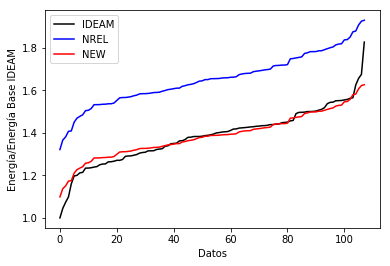

In [10]:
pylab.xlabel("Datos")
pylab.ylabel("Energía/Energía Base IDEAM")
numdatos = range(len(datos_IDEAM))
pylab.plot(numdatos,datos_IDEAM/datos_IDEAM[0],'-k', label='IDEAM')
pylab.plot(numdatos,datos_NREL/datos_IDEAM[0],'-b', label='NREL')
pylab.plot(numdatos,datos_NEW/datos_IDEAM[0],'-r', label='NEW')
pylab.legend(loc='upper left')
pylab.savefig(os.path.join(output_dir,ciudad+'.png'), dpi=600)

### Error RMSEn

In [11]:
# Param: serie OBJ, serie corregida/nueva cortada
def rmsen(obj,cor):
    
    nom_ener_obj = list(obj)[-1]
    nom_ener_cor = list(cor)[-1]
    
    n = len(cor)
    resta = []
    i_min = cor.first_valid_index() 

    for i in range(n):
        x_obj = obj[nom_ener_obj][i]
        x_cor = cor[nom_ener_cor][i+i_min]
        
        x = (x_obj - x_cor)**2
        
        resta.append(x)
    
    error = np.sqrt((1/n)*sum(resta))/(np.max(obj[nom_ener_obj]) - np.min(obj[nom_ener_obj]))
    
    return error        

In [12]:
error_rmsen = rmsen(serie_pd_OBJ,nueva_cort)

In [13]:
error_rmsen

0.10227907240676384

### Error MBE

In [14]:
# Param: serie OBJ, serie corregida/nueva cortada
def mbe(obj,cor):
    
    nom_ener_obj = list(obj)[-1]
    nom_ener_cor = list(cor)[-1]
    
    n = len(cor)
    resta = []
    
    i_min = cor.first_valid_index() 

    for i in range(n):
        x_obj = obj[nom_ener_obj][i]
        x_cor = cor[nom_ener_cor][i+i_min]
        
        x = (x_cor - x_obj)
        
        resta.append(x)
    
    error = sum(resta)/sum(obj[nom_ener_obj])
    
    return error

In [15]:
error_mbe = mbe(serie_pd_OBJ,nueva_cort)

In [16]:
error_mbe

0.00033977030436991966

In [17]:
min_agnos

9